<a href="https://colab.research.google.com/github/ali3brt/20-Newsgroups-Dataset/blob/main/Generative_AI(Autoencoder%2C_Variational_Autoencoder%2C_GANs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0319 - val_loss: 0.0127
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0097 - val_loss: 0.0087
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 1/10, VAE Loss: 608.6793212890625
Epoch 2/10, VAE Loss: 605.7876586914062
Epoch 3/10, VAE Loss: 599.097900390625
Epoch 4/10, VAE

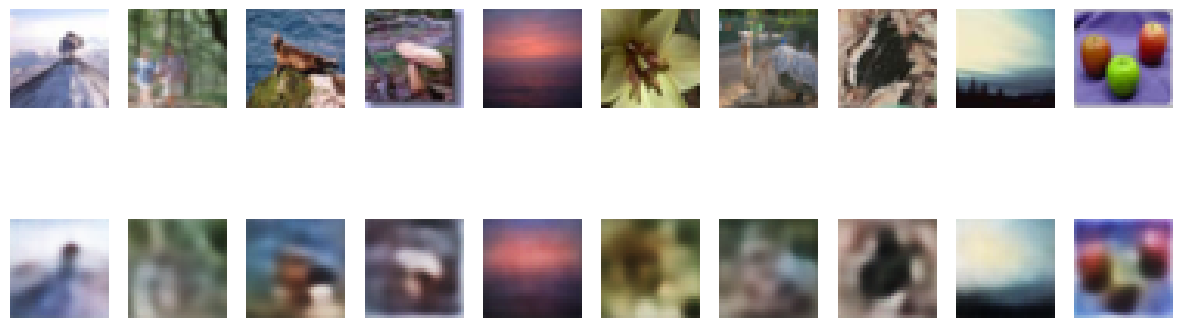

ValueError: Input 0 of layer "functional_34" is incompatible with the layer: expected shape=(None, 128), found shape=(10, 32, 32, 3)

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.losses import MeanSquaredError

# Load CFAR100 dataset
(train_images, _), (test_images, _) = datasets.cifar100.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Reshape images
train_images = np.reshape(train_images, (train_images.shape[0], 32, 32, 3))
test_images = np.reshape(test_images, (test_images.shape[0], 32, 32, 3))

# Create Autoencoder Model (AE)
def build_autoencoder():
    # Encoder
    encoder_input = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(encoder_input)
    x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(128, activation='relu')(x)

    # Decoder
    x = Dense(4*4*128, activation='relu')(encoded)
    x = Reshape((4, 4, 128))(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
    decoder_output = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(encoder_input, decoder_output)
    autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

    return autoencoder

# Create Variational Autoencoder Model (VAE)
class VAE(Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder_input = Input(shape=(32, 32, 3))

        # Encoder layers
        x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(self.encoder_input)
        x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = Flatten()(x)

        # Latent variables
        self.z_mean = Dense(128, name="z_mean")(x)
        self.z_log_var = Dense(128, name="z_log_var")(x)

        self.encoder = Model(self.encoder_input, [self.z_mean, self.z_log_var])

        # Decoder
        latent_inputs = Input(shape=(128,))
        x = Dense(4*4*128, activation='relu')(latent_inputs)
        x = Reshape((4, 4, 128))(x)
        x = Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
        x = Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
        decoder_output = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

        self.decoder = Model(latent_inputs, decoder_output)

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Loss for Variational Autoencoder
def vae_loss(x, x_reconstructed, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_reconstructed), axis=(1, 2)))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    return reconstruction_loss + kl_loss

# Instantiate and compile both models
autoencoder = build_autoencoder()
vae = VAE()

vae.compile(optimizer='adam', loss=lambda x, x_reconstructed: vae_loss(x, x_reconstructed, vae.z_mean, vae.z_log_var))

# Training the models
epochs = 10
batch_size = 64

# Train Autoencoder
autoencoder.fit(train_images, train_images, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_images))

# Train Variational Autoencoder
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)
for epoch in range(epochs):
    for x_batch in train_dataset:
        with tf.GradientTape() as tape:
            reconstructed, z_mean, z_log_var = vae(x_batch)
            loss = vae_loss(x_batch, reconstructed, z_mean, z_log_var)
        grads = tape.gradient(loss, vae.trainable_variables)
        vae.optimizer.apply_gradients(zip(grads, vae.trainable_variables))
    print(f"Epoch {epoch + 1}/{epochs}, VAE Loss: {loss.numpy()}")

# Visualization of reconstruction results
def plot_reconstruction(model, data, num_images=10):
    reconstructed_images = model.predict(data[:num_images])
    fig, axs = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        axs[0, i].imshow(data[i])
        axs[0, i].axis('off')
        axs[1, i].imshow(reconstructed_images[i])
        axs[1, i].axis('off')
    plt.show()

# Visualizing AE and VAE reconstructions
plot_reconstruction(autoencoder, test_images)
plot_reconstruction(vae.decoder, test_images)
